In [1]:
#Add libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore")



In [2]:
#Import CSV 
Crypto = pd.read_csv("/kaggle/input/top-1000-cryptos-historical/1000_cryptos.csv", index_col= 0) 
print(Crypto)

             Date      Open      High       Low     Close  Adj Close  \
0      2020-08-01  0.000000  0.000000  0.000000  0.000000   0.000000   
1      2020-08-02  0.000000  0.000000  0.000000  0.000000   0.000000   
2      2020-08-03  0.000000  0.000000  0.000000  0.000000   0.000000   
3      2020-08-04  0.000000  0.000000  0.000000  0.000000   0.000000   
4      2020-08-05  0.000000  0.000000  0.000000  0.000000   0.000000   
...           ...       ...       ...       ...       ...        ...   
48473  2024-08-20  0.598610  0.614521  0.588849  0.594428   0.594428   
48474  2024-08-21  0.594427  0.605304  0.586758  0.600275   0.600275   
48475  2024-08-22  0.600277  0.603866  0.593852  0.597601   0.597601   
48476  2024-08-23  0.597600  0.615634  0.594322  0.611239   0.611239   
48477  2024-08-24  0.611264  0.629285  0.605646  0.622912   0.622912   

             Volume   Symbol  
0      1.604789e+06  BTC-USD  
1      1.930980e+05  BTC-USD  
2      1.292250e+05  BTC-USD  
3      1.97

In [3]:
#Exploring DATA
Crypto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48478 entries, 0 to 48477
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       48478 non-null  object 
 1   Open       48408 non-null  float64
 2   High       48408 non-null  float64
 3   Low        48408 non-null  float64
 4   Close      48408 non-null  float64
 5   Adj Close  48408 non-null  float64
 6   Volume     48408 non-null  float64
 7   Symbol     48478 non-null  object 
dtypes: float64(6), object(2)
memory usage: 3.3+ MB


In [4]:
# Group by symbol and calculate descriptive statistics
symbols = Crypto['Symbol'].unique()

# Dictionary to store the descriptive statistics
descriptive_stats = {}

#Iterate over each symbol and calculate statistics
for symbol in symbols:
    # Filter the DataFrame by the current symbol
    symbol_Crypto = Crypto[Crypto['Symbol'] == symbol]

    # Calculate descriptive statistics for this symbol
    stats = symbol_Crypto.describe().loc[['count', 'mean', 'std', 'min', '25%', '50%', '75%']]

    # Transpose the result so that statistics are columns
    stats = stats.T

    # Add the symbol as the row name
    stats.name = symbol

    # Store the statistics in the dictionary
    descriptive_stats[symbol] = stats



In [5]:
#Most Volatile Cryptos
# List to store volatility data
volatility_data = []

# Iterate over each symbol and calculate standard deviation
for symbol in Crypto['Symbol'].unique():
    # Filter the DataFrame by the current symbol
    symbol_Crypto = Crypto[Crypto['Symbol'] == symbol]
    
    # Calculate the standard deviation of the 'Close' column
    std_dev = symbol_Crypto['Close'].std()

    # Add the symbol and standard deviation to the list
    volatility_data.append([symbol, std_dev])

# Create a DataFrame from the list
volatility_Crypto = pd.DataFrame(volatility_data, columns=['Symbol', 'Volatility'])

# Sort by descending volatility and show the top 20
top_10_volatile = volatility_Crypto.sort_values('Volatility', ascending=False).head(10)


print(top_10_volatile)

          Symbol    Volatility
9       DOGE-USD  19464.243804
5        XRP-USD  19022.613064
3        BNB-USD   1217.739712
8   TON11419-USD   1206.947166
20       BCH-USD   1006.891002
22      NEAR-USD    893.341323
1        ETH-USD    404.761163
15      WBTC-USD    196.637513
11      WTRX-USD     61.678301
2       USDT-USD     26.151747


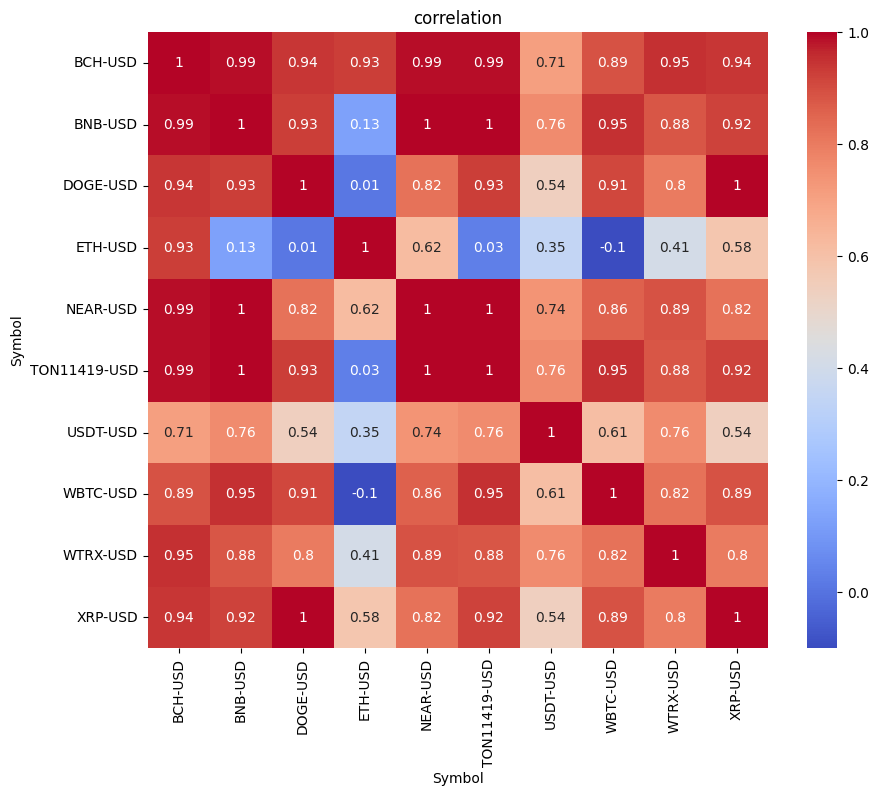

In [6]:
# Is there correlation among the 10 most volatile cryptos?
# Filter the original data for the 10 most volatile cryptocurrencies
filtered_df = Crypto[Crypto['Symbol'].isin(top_10_volatile['Symbol'])]

# Pivot the DataFrame to have cryptocurrencies as columns
pivoted_df = filtered_df.pivot(index='Date', columns='Symbol', values='Close')  # Reemplaza 'Close' si tu columna de precios tiene otro nombre

# Calculate the correlation matrix
correlation_matrix = pivoted_df.corr().round(2)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('correlation')
plt.show()


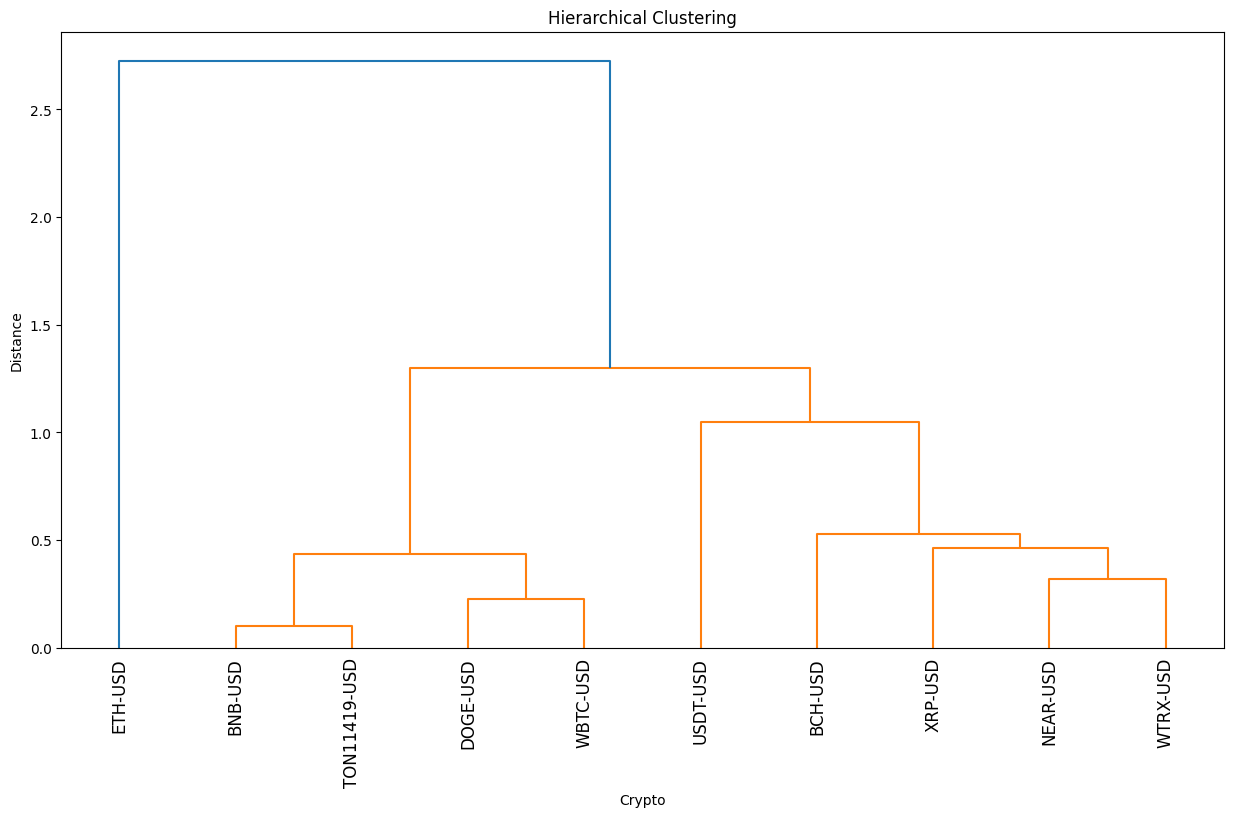

In [7]:
#Hierarchical Clustering

Z = linkage(correlation_matrix, 'ward')  

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=correlation_matrix.index, leaf_rotation=90)
plt.title('Hierarchical Clustering')
plt.xlabel('Crypto')
plt.ylabel('Distance')
plt.show()

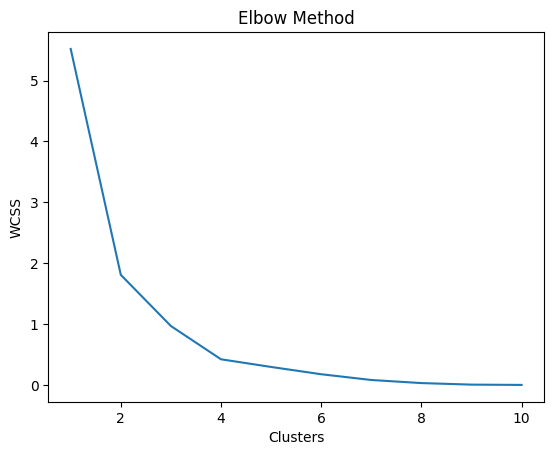

| Symbol       | Cluster   |
|:-------------|:----------|
| BCH-USD      | 0         |
| BNB-USD      | 2         |
| DOGE-USD     | 2         |
| ETH-USD      | 1         |
| NEAR-USD     | 0         |
| TON11419-USD | 2         |
| USDT-USD     | 0         |
| WBTC-USD     | 2         |
| WTRX-USD     | 0         |
| XRP-USD      | 0         |


In [8]:
#Clustering K-means

#Determine the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(correlation_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(correlation_matrix)

#Make a DataFrame with clustering result 
cluster_results_df = pd.DataFrame({'Symbol': pivoted_df.columns, 'Cluster': kmeans.labels_})
cluster_results_df.reset_index(drop=True, inplace=True)

# Merger cluster_results_df and filtered_df 
filtered_df_with_clusters = filtered_df.reset_index().merge(cluster_results_df, on='Symbol', how='left').set_index('Date')

print(cluster_results_df.to_markdown(index=False, numalign='left', stralign='left'))

In [9]:
# Descriptive statistics by cluster

cluster_stats = filtered_df_with_clusters.groupby('Cluster')['Close'].describe()
print(cluster_stats.round(1))


           count    mean      std   min    25%     50%     75%      max
Cluster                                                                
0         7461.0  8713.1  15949.5   0.5   34.7  1783.7  7329.7  73027.8
1         2481.0   426.4    404.8  77.4  213.3   294.8   499.0   3923.1
2        10900.0  6528.0  13674.8   1.5  241.0  1013.3  3763.8  73083.5


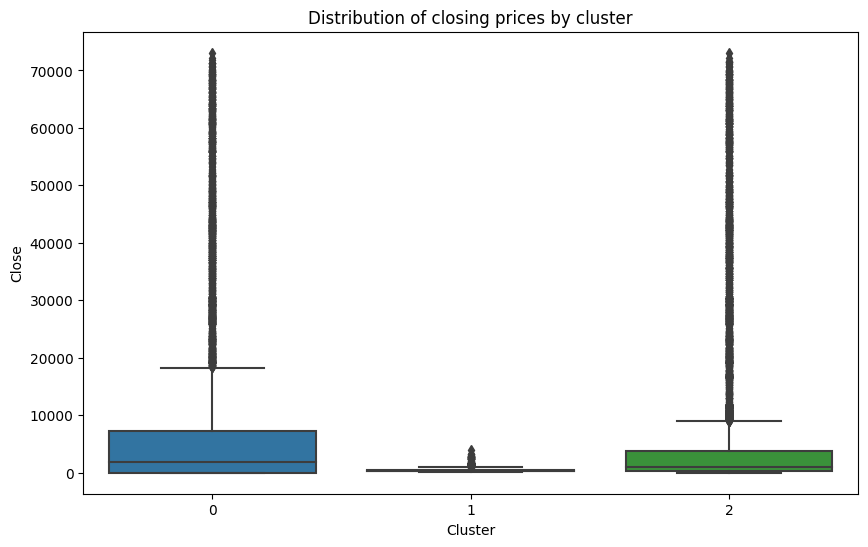

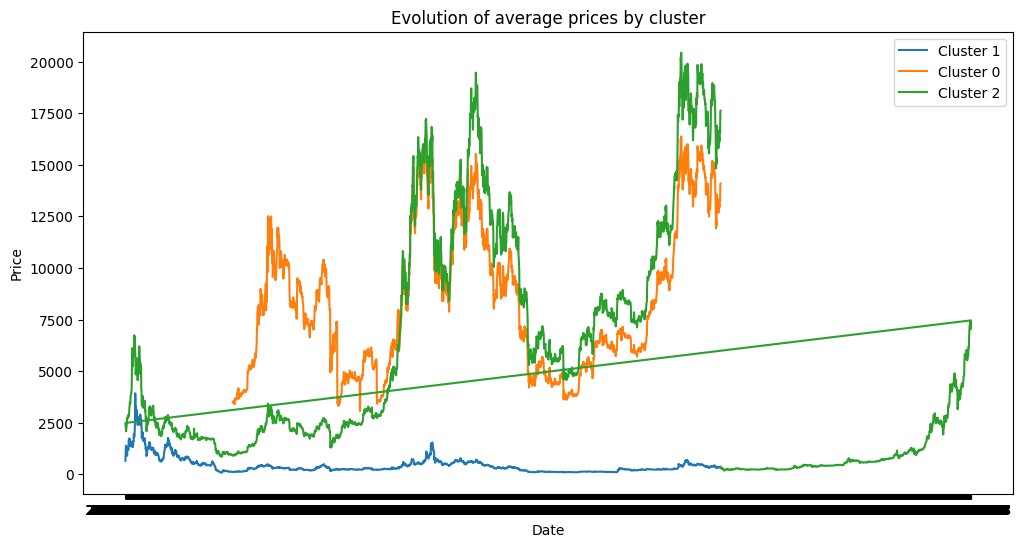

In [10]:
#Cluster Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Close', data=filtered_df_with_clusters)
plt.title('Distribution of closing prices by cluster')
plt.show()

#Average price time series by cluster
plt.figure(figsize=(12, 6))
for cluster_id in filtered_df_with_clusters['Cluster'].unique():
    cluster_data = filtered_df_with_clusters[filtered_df_with_clusters['Cluster'] == cluster_id]
    plt.plot(cluster_data.groupby('Date')['Close'].mean(), label=f'Cluster {cluster_id}')
plt.title('Evolution of average prices by cluster')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()